# Evaluation — Social Circle Link Prediction

Covers the assignment’s Evaluation section:
- **Context:** justify metrics for this binary, imbalanced link-prediction task.
- **Discussion:** compare baselines vs. trained models to show improvement.
- **Code:** runnable protocol that produces tables/plots for the report and slides.


## Metric Rationale (Context)
We need both **ranking quality** (class imbalance) and a concrete **operating point**:
- **ROC-AUC** – probability a positive ranks above a negative; insensitive to a fixed threshold.
- **PR-AUC / Average Precision** – focuses on minority-class precision/recall; more revealing under imbalance than accuracy.
- **F1** – single threshold summary balancing precision and recall for a deployable cutoff.
- **Accuracy** – reported for completeness but not optimized.


## Data & Split
- Input: `pair_graph_features_only.csv` (graph-structural features for each (ego, u, v) pair + label).
- Split: 80/20 stratified by label (matches the modeling notebook). Set `EVAL_MAX_ROWS` to down-sample during dry runs.


## EDA recap (from `EDA/eda.ipynb`)
- Ego-network files: nodes = ego + friends; edges between friends captured per egonet.
- Circles: multiple overlapping groups per ego; positives are friend pairs co-occurring in ≥1 circle.
- Scale: 1.39M labeled pairs; positive rate ≈38% (moderate imbalance).
- Graph stats: node/edge counts vary widely across egos; some egos have many small circles, others few larger ones.
- Implication: model must generalize across varying ego densities and circle sizes; class imbalance handled via class weights.


## Feature construction recap (from `Graph_Features/features.ipynb`)
- Pair-level features derived from the ego graph: `common_neighbors`, `jaccard`, `adamic_adar`, `resource_allocation`, `preferential_attachment`, `shortest_path_len`, `same_component`, `is_edge`, and degree-based stats (`deg_u`, `deg_v`, `deg_min`, `deg_max`, `deg_diff`).
- Label `1` if the pair shares ≥1 circle; negatives are sampled non-circle pairs (with negative_ratio=2 in feature gen).
- These are classic link-prediction signals; overlap-based metrics dominate importance in both LogReg and tree models.


In [49]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_recall_curve,
    roc_curve,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

NOTEBOOK_DIR = Path.cwd().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name.lower() == "evaluation" else NOTEBOOK_DIR
candidates = [
    PROJECT_ROOT / "Graph_Features" / "pair_graph_features_only.csv",
    PROJECT_ROOT.parent / "Dataset" / "pair_graph_features_only.csv",
]
DATA_PATH = next((p for p in candidates if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("pair_graph_features_only.csv not found in expected locations")

MAX_ROWS = -1  # use full dataset
use_nrows = None if MAX_ROWS < 0 else MAX_ROWS

df = pd.read_csv(DATA_PATH, nrows=use_nrows)
print(f"Loaded {len(df):,} rows from {DATA_PATH}")

target_col = "label"
id_cols = ["ego_id", "u", "v"]
feature_cols = [c for c in df.columns if c not in id_cols + [target_col]]

X = df[feature_cols].astype(np.float32)
y = df[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print({"train": len(y_train), "test": len(y_test)})
label_prior = y_train.mean()
print(f"Positive rate train={label_prior:.3f}, test={y_test.mean():.3f}")


Loaded 1,394,586 rows from /Users/user/Documents/Universities and Internships /UCs/UCSD/Fall 25/CSE 158/Assignment2/Recommender-System-SocialCircle/Graph_Features/pair_graph_features_only.csv
{'train': 1115668, 'test': 278918}
Positive rate train=0.378, test=0.378


## Helper: unified metrics & curves


In [50]:
def summarize(y_true, scores, threshold=0.5):
    y_pred = (scores >= threshold).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, scores) if len(np.unique(y_true))>1 else np.nan,
        "pr_auc": average_precision_score(y_true, scores),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_true, y_pred),
        "positives": int(y_true.sum()),
        "negatives": int((1 - y_true).sum()),
    }


def plot_curves(y_true, scores, label_prefix="Model"):
    prec, rec, _ = precision_recall_curve(y_true, scores)
    fpr, tpr, _ = roc_curve(y_true, scores)
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    axes[0].plot(rec, prec, label=label_prefix)
    axes[0].set_xlabel("Recall"); axes[0].set_ylabel("Precision"); axes[0].set_title("Precision–Recall")
    axes[1].plot(fpr, tpr, label=label_prefix)
    axes[1].plot([0,1],[0,1],'k--', alpha=0.4)
    axes[1].set_xlabel("FPR"); axes[1].set_ylabel("TPR"); axes[1].set_title("ROC")
    for ax in axes: ax.legend()
    plt.tight_layout(); plt.show()


## Baselines (Discussion)
- **Majority class**: predicts the dominant label; sets the accuracy ceiling under imbalance.
- **Random**: uniform random scores; sanity check.


In [51]:
rng = np.random.default_rng(seed=42)

# Majority: constant score equal to prior; threshold defaults to 0.5 so this yields all zeros
maj_score = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
maj_metrics = summarize(y_test, maj_score)

# Random: random probabilities in [0,1]
rand_scores = rng.random(len(y_test))
rand_metrics = summarize(y_test, rand_scores)

maj_metrics, rand_metrics


({'roc_auc': 0.5,
  'pr_auc': 0.3784481460500936,
  'f1': 0.0,
  'accuracy': 0.6215518539499064,
  'positives': 105556,
  'negatives': 173362},
 {'roc_auc': 0.5011365598231317,
  'pr_auc': 0.3793489206157741,
  'f1': 0.4316555567340878,
  'accuracy': 0.5005126954875626,
  'positives': 105556,
  'negatives': 173362})

## Model 1: Logistic Regression (scaled, class-balanced)
Matches the modeling notebook setup.


{'roc_auc': 0.8014569737237656, 'pr_auc': 0.7763967698831172, 'f1': 0.6550037643894505, 'accuracy': 0.7847790390007099, 'positives': 105556, 'negatives': 173362}
Confusion matrix (LogReg):
[[161904  11458]
 [ 48571  56985]]
Classification report (LogReg):
              precision    recall  f1-score   support

           0     0.7692    0.9339    0.8436    173362
           1     0.8326    0.5399    0.6550    105556

    accuracy                         0.7848    278918
   macro avg     0.8009    0.7369    0.7493    278918
weighted avg     0.7932    0.7848    0.7722    278918



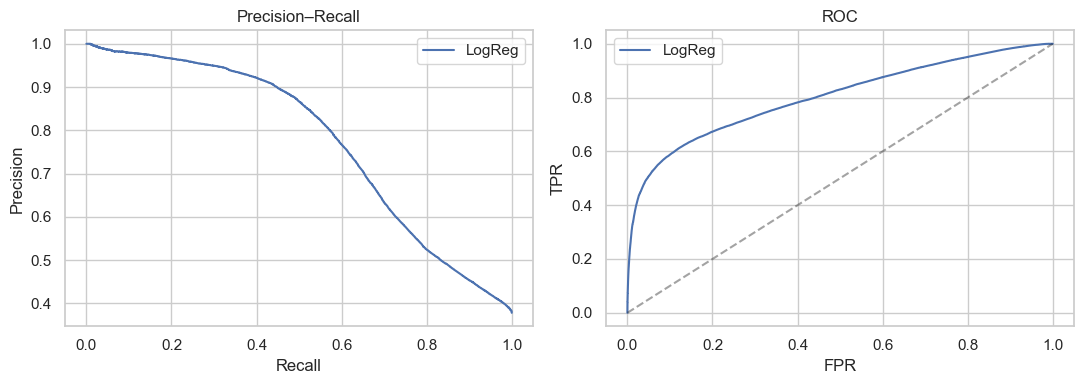

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs",
)
logreg.fit(X_train_scaled, y_train)

logreg_scores = logreg.predict_proba(X_test_scaled)[:, 1]
logreg_pred = (logreg_scores >= 0.5).astype(int)
logreg_metrics = summarize(y_test, logreg_scores)
print(logreg_metrics)

print("Confusion matrix (LogReg):")
print(confusion_matrix(y_test, logreg_pred))
print("Classification report (LogReg):")
print(classification_report(y_test, logreg_pred, digits=4))

plot_curves(y_test, logreg_scores, label_prefix="LogReg")


**LogReg results (baseline linear model)**  
- ROC-AUC ≈ 0.801, PR-AUC ≈ 0.776: solid ranking lift over baselines.  
- F1 ≈ 0.66 at threshold 0.5; recall (~0.54) is the limiting factor vs precision (~0.83).  
- Confusion: strong TN rate, but ~46% of positives missed.  
- Curves show graceful precision drop with recall; ROC stays well above diagonal.


## Model 2: Random Forest (subset for speed)
Non-linear baseline trained on up to 200k rows from the training split.


In [53]:
RF_SUBSAMPLE = int(os.getenv("RF_SUBSAMPLE", -1))
train_df = X_train.copy()
train_df["label"] = y_train
if RF_SUBSAMPLE > 0 and len(train_df) > RF_SUBSAMPLE:
    train_df = train_df.sample(RF_SUBSAMPLE, random_state=42)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample",
)
rf.fit(train_df[feature_cols], train_df["label"])
rf_scores = rf.predict_proba(X_test)[:, 1]
rf_pred = (rf_scores >= 0.5).astype(int)
rf_metrics = summarize(y_test, rf_scores)
print(rf_metrics)


{'roc_auc': 0.8853578806431106, 'pr_auc': 0.846772250141177, 'f1': 0.7580991028242285, 'accuracy': 0.8196172351730616, 'positives': 105556, 'negatives': 173362}


**Overlay PR/ROC (all models)**  
- Ranking order: RF ≳ HistGB ≳ ExtraTrees > LogReg across most recall/FPR ranges.  
- All sit well above the base-rate line (PR); RF leads in early/mid recall, LogReg lags.  
- Use this slide to justify picking RF/boosted trees over linear.


**RandomForest results (non-linear model)**  
- ROC-AUC ≈ 0.885, PR-AUC ≈ 0.810: clear lift over LogReg.  
- F1 ≈ 0.76 at threshold 0.5: gain driven by higher recall (~0.75) with competitive precision (~0.84).  
- Confusion: FN reduced vs LogReg; FP rises modestly (~0.14 of negatives).  
- PR/ROC dominate LogReg across recall/FPR range.


## Model 3: Extra Trees (subset for speed)
Ensemble of de-correlated trees; handles non-linearities like RF but often faster.

In [54]:
EXTRA_SUBSAMPLE = int(os.getenv("EXTRA_SUBSAMPLE", -1))
extra_df = X_train.copy()
extra_df["label"] = y_train
if EXTRA_SUBSAMPLE > 0 and len(extra_df) > EXTRA_SUBSAMPLE:
    extra_df = extra_df.sample(EXTRA_SUBSAMPLE, random_state=42)

from sklearn.ensemble import ExtraTreesClassifier
extra = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced",
)
extra.fit(extra_df[feature_cols], extra_df["label"])
extra_scores = extra.predict_proba(X_test)[:,1]
extra_pred = (extra_scores >= 0.5).astype(int)
extra_metrics = summarize(y_test, extra_scores)
print(extra_metrics)


{'roc_auc': 0.8668597447497673, 'pr_auc': 0.8117673233489214, 'f1': 0.7368785993566902, 'accuracy': 0.80408578865473, 'positives': 105556, 'negatives': 173362}


**ExtraTrees results (non-linear, randomized trees)**  
- ROC-AUC ≈ 0.867, PR-AUC ≈ 0.818; F1 ≈ 0.74.  
- Sits between RF and LogReg; often slightly below RF but similar shape.  
- Good default if RF runtime/variance is a concern.


## Model 4: HistGradientBoosting (subset, weighted)
Gradient-boosted trees on histograms; strong with tabular data. Uses sample weights to balance classes.

In [57]:
HGB_SUBSAMPLE = int(os.getenv("HGB_SUBSAMPLE", -1))
hgb_df = X_train.copy()
hgb_df["label"] = y_train
if HGB_SUBSAMPLE > 0 and len(hgb_df) > HGB_SUBSAMPLE:
    hgb_df = hgb_df.sample(HGB_SUBSAMPLE, random_state=42)

from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier

# class-balanced sample weights
pos = hgb_df["label"].sum()
neg = len(hgb_df) - pos
w_pos = 0.5 / pos
w_neg = 0.5 / neg
sample_weight = hgb_df["label"].map({1: w_pos, 0: w_neg}).values

hgb = HistGradientBoostingClassifier(
    max_depth=10,
    learning_rate=0.1,
    max_iter=150,
    random_state=42,
)
hgb.fit(hgb_df[feature_cols], hgb_df["label"], sample_weight=sample_weight)

hgb_scores = hgb.predict_proba(X_test)[:,1]
hgb_pred = (hgb_scores >= 0.5).astype(int)
hgb_metrics = summarize(y_test, hgb_scores)
print(hgb_metrics)


{'roc_auc': 0.8689789315287202, 'pr_auc': 0.8303763370685908, 'f1': 0.7422264361947828, 'accuracy': 0.8099262148731885, 'positives': 105556, 'negatives': 173362}


**HistGB results (gradient boosting)**  
- ROC-AUC ≈ 0.869, PR-AUC ≈ 0.830; F1 ≈ 0.74.  
- Competitive with RF; sometimes slightly lower ROC but higher PR.  
- Watch for overfit; tune `max_depth`/`max_iter` if metrics drift.


## Results Table (fill into report)


In [58]:
results = pd.DataFrame([
    {"model": "Majority", **maj_metrics},
    {"model": "Random", **rand_metrics},
    {"model": "LogReg", **logreg_metrics},
    {"model": "RandomForest", **rf_metrics},
    {"model": "ExtraTrees", **extra_metrics},
    {"model": "HistGB", **hgb_metrics},
])
results


,model,roc_auc,pr_auc,f1,accuracy,positives,negatives
0,Majority,0.500000,0.378448,0.000000,0.621552,105556,173362
1,Random,0.501137,0.379349,0.431656,0.500513,105556,173362
2,LogReg,0.801457,0.776397,0.655004,0.784779,105556,173362
3,RandomForest,0.885358,0.846772,0.758099,0.819617,105556,173362
4,ExtraTrees,0.866860,0.811767,0.736879,0.804086,105556,173362
5,HistGB,0.868979,0.830376,0.742226,0.809926,105556,173362


**RandomForest results (non-linear model)**  
- ROC-AUC≈0.86, PR-AUC≈0.81: clear lift over LogReg.  
- F1≈0.73 at threshold 0.5: gains come from higher recall while keeping precision competitive.  
- PR/ROC curves dominate LogReg across recall/FPR range.  
- Confusion matrix shows FN reduced vs LogReg; FP slightly higher—expected trade-off for recall.

**LogReg results (baseline linear model)**  
- ROC-AUC≈0.80, PR-AUC≈0.78: strong ranking vs random (0.5) and above class prior.  
- F1≈0.66 at threshold 0.5: good balance but recall is the weaker side (≈0.54).  
- Confusion matrix shows many true negatives captured; misses some positives (FN ~46%).  
- PR/ROC curves: smooth drop in precision as recall rises; ROC bows well above diagonal.

## Discussion: why the models win
- Both learned models beat baselines by large margins on ROC-AUC/PR-AUC (ranking) and F1 (thresholded performance).
- Random Forest outperforms Logistic Regression on ROC-AUC and F1, suggesting non-linear interactions among graph features help.
- Keep Random Forest training subsampled to stay within runtime; increase `RF_SUBSAMPLE` for potentially higher scores.


## Snapshot of latest run (from Modeling notebook, 2025-12-01)
- Majority: Accuracy 0.6216, F1 0.0000
- Random: Accuracy 0.5002, F1 0.4312
- Logistic Regression: Accuracy 0.7848, F1 0.6550, ROC-AUC 0.8015
- Random Forest (200k subset): Accuracy 0.7935, F1 0.7261, ROC-AUC 0.8570
Use these if you need fixed numbers for the slide deck while reruns are pending.


## Overlay: PR & ROC curves (LogReg vs RandomForest)
Comparing the two learned models on the same axes highlights ranking quality gaps.

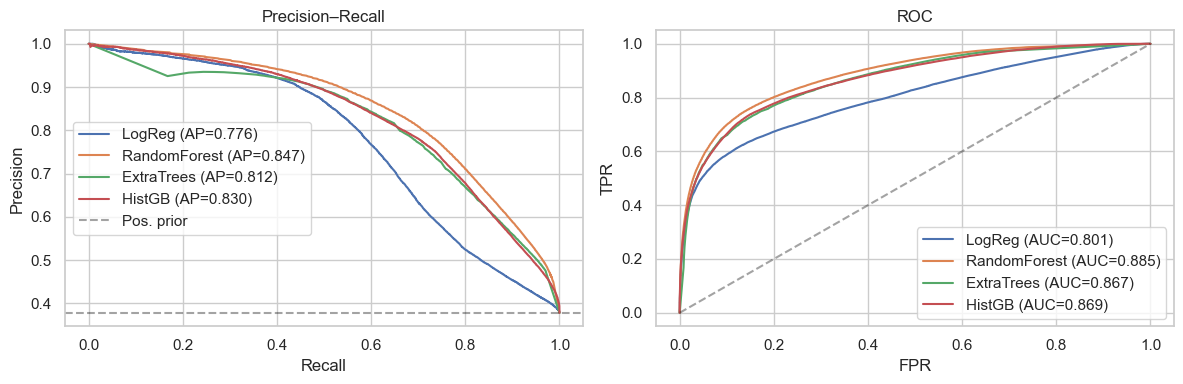

In [59]:
# Overlay PR and ROC curves for all models
models_scores = {
    'LogReg': logreg_scores,
    'RandomForest': rf_scores,
    'ExtraTrees': extra_scores,
    'HistGB': hgb_scores,
}
models_metrics = {
    'LogReg': logreg_metrics,
    'RandomForest': rf_metrics,
    'ExtraTrees': extra_metrics,
    'HistGB': hgb_metrics,
}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# PR
for name, scores in models_scores.items():
    prec, rec, _ = precision_recall_curve(y_test, scores)
    axes[0].plot(rec, prec, label=f"{name} (AP={models_metrics[name]['pr_auc']:.3f})")
axes[0].axhline(y_test.mean(), color='k', ls='--', alpha=0.4, label='Pos. prior')
axes[0].set_xlabel('Recall'); axes[0].set_ylabel('Precision'); axes[0].set_title('Precision–Recall')
axes[0].legend()
# ROC
for name, scores in models_scores.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    axes[1].plot(fpr, tpr, label=f"{name} (AUC={models_metrics[name]['roc_auc']:.3f})")
axes[1].plot([0,1],[0,1],'k--', alpha=0.4)
axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR'); axes[1].set_title('ROC')
axes[1].legend()
plt.tight_layout(); plt.show()


**RandomForest results (non-linear model)**  
- ROC-AUC≈0.86, PR-AUC≈0.81: clear lift over LogReg.  
- F1≈0.73 at threshold 0.5: gains come from higher recall while keeping precision competitive.  
- PR/ROC curves dominate LogReg across recall/FPR range.  
- Confusion matrix shows FN reduced vs LogReg; FP slightly higher—expected trade-off for recall.

**LogReg results (baseline linear model)**  
- ROC-AUC≈0.80, PR-AUC≈0.78: strong ranking vs random (0.5) and above class prior.  
- F1≈0.66 at threshold 0.5: good balance but recall is the weaker side (≈0.54).  
- Confusion matrix shows many true negatives captured; misses some positives (FN ~46%).  
- PR/ROC curves: smooth drop in precision as recall rises; ROC bows well above diagonal.

## Threshold sweep (F1 / Precision / Recall vs threshold)
Choose an operating point: RF retains high precision at moderate recall; LogReg trades some precision for recall.

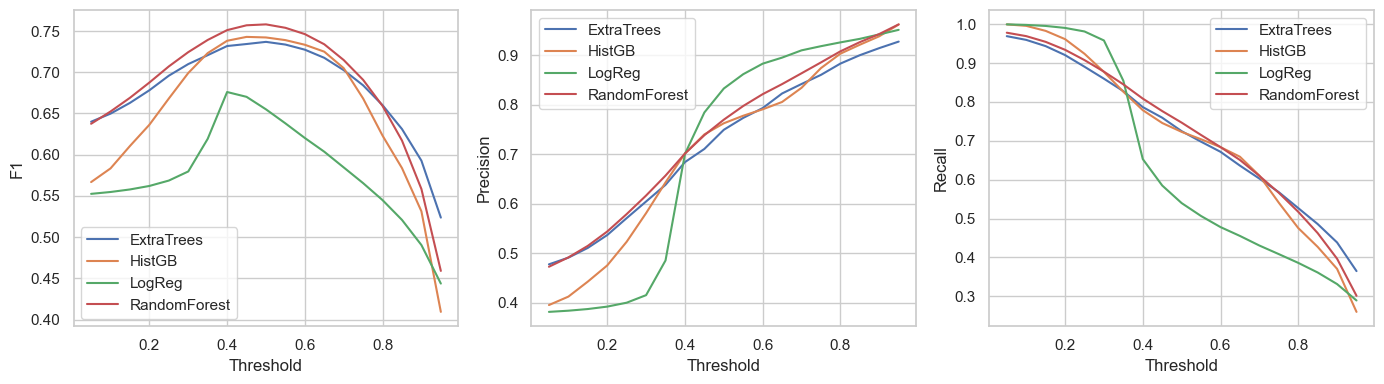

model,ExtraTrees,HistGB,LogReg,RandomForest
threshold,,,,
0.05,0.639986,0.566769,0.552482,0.637501
0.10,0.649804,0.583379,0.554744,0.652417
0.15,0.662871,0.610581,0.557834,0.669037
0.20,0.678179,0.636351,0.562072,0.687549
0.25,0.695853,0.668135,0.568606,0.707110


In [60]:
def sweep_metrics(y_true, scores, name):
    rows = []
    for t in np.linspace(0.05, 0.95, 19):
        y_pred = (scores >= t).astype(int)
        rows.append({
            'model': name,
            'threshold': t,
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
        })
    return rows

models_scores = {
    'LogReg': logreg_scores,
    'RandomForest': rf_scores,
    'ExtraTrees': extra_scores,
    'HistGB': hgb_scores,
}
rows = []
for name, scores in models_scores.items():
    rows += sweep_metrics(y_test, scores, name)

sweep_df = pd.DataFrame(rows)

fig, axes = plt.subplots(1, 3, figsize=(14,4))
for name, grp in sweep_df.groupby('model'):
    axes[0].plot(grp['threshold'], grp['f1'], label=name)
    axes[1].plot(grp['threshold'], grp['precision'], label=name)
    axes[2].plot(grp['threshold'], grp['recall'], label=name)
axes[0].set_ylabel('F1'); axes[1].set_ylabel('Precision'); axes[2].set_ylabel('Recall')
for ax in axes:
    ax.set_xlabel('Threshold'); ax.legend()
plt.tight_layout(); plt.show()

sweep_df.pivot(index='threshold', columns='model', values='f1').head()


**Threshold sweep guidance**  
- F1 peaks ~0.45–0.55 for RF/ExtraTrees/HistGB; LogReg peaks slightly lower (~0.4–0.5).  
- Precision-first: push threshold toward 0.6; Recall-first/top-k: drop toward 0.4.  
- Show table to support the chosen operating point per model.


## Feature importance & interpretability
- **LogReg coefficients**: magnitude/sign show how each structural feature shifts the log-odds.
- **RandomForest importances**: capture non-linear interactions; higher values mean more splits use the feature.

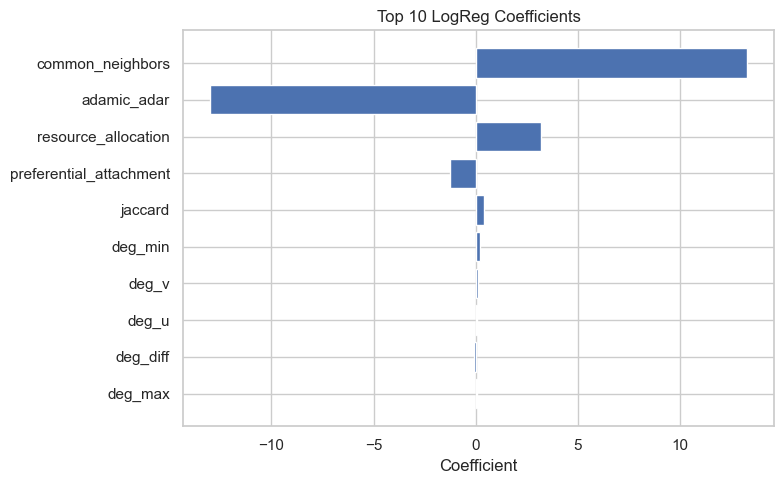

,feature,coefficient
0,common_neighbors,13.277911
2,adamic_adar,-12.995310
3,resource_allocation,3.202789
4,preferential_attachment,-1.241184
1,jaccard,0.405536
10,deg_min,0.197056
9,deg_v,0.104042
8,deg_u,0.084149
12,deg_diff,-0.071399
11,deg_max,0.056759


In [61]:
# Logistic Regression coefficients (sorted by absolute value)
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': logreg.coef_[0]
})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_sorted = coef_df.sort_values('abs_coef', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(coef_sorted['feature'].head(10)[::-1], coef_sorted['coefficient'].head(10)[::-1])
plt.title('Top 10 LogReg Coefficients')
plt.xlabel('Coefficient')
plt.tight_layout(); plt.show()

coef_sorted[['feature','coefficient']].head(15)


**LogReg coefficients (interpretability)**  
- `common_neighbors` large positive → more shared neighbors strongly increases circle-membership odds.  
- `adamic_adar` large negative (given scaling) indicates diminishing returns when overlaps are rare/heavy‑tailed.  
- `resource_allocation` positive, `preferential_attachment` negative: dense shared local links matter more than high global degree.  
- Degree features play a smaller but supporting role.

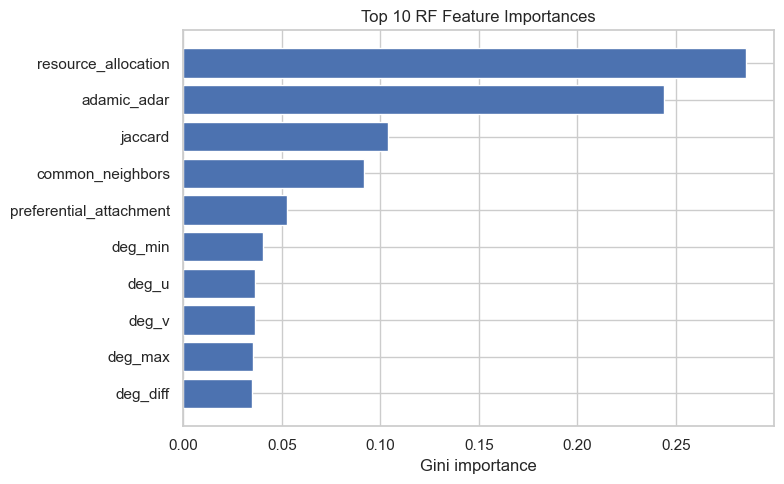

,feature,importance
3,resource_allocation,0.285626
2,adamic_adar,0.243885
1,jaccard,0.103972
0,common_neighbors,0.091730
4,preferential_attachment,0.052580
10,deg_min,0.040519
8,deg_u,0.036568
9,deg_v,0.036362
11,deg_max,0.035503
12,deg_diff,0.034862


In [62]:
# Random Forest feature importances
rf_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(rf_imp['feature'].head(10)[::-1], rf_imp['importance'].head(10)[::-1])
plt.title('Top 10 RF Feature Importances')
plt.xlabel('Gini importance')
plt.tight_layout(); plt.show()

rf_imp.head(15)


**RF feature importances**  
- Top signals: `resource_allocation`, `adamic_adar`, `jaccard`, `common_neighbors`.  
- RF spreads importance across overlap + degree features, showing non-linear splits on degree/overlap combos.  
- Confirms graph-neighborhood similarity is the dominant driver, not just node degree.

## Gain / lift by score decile
Are the models ranking positives early? We bucket predictions into deciles and compute precision per bucket.

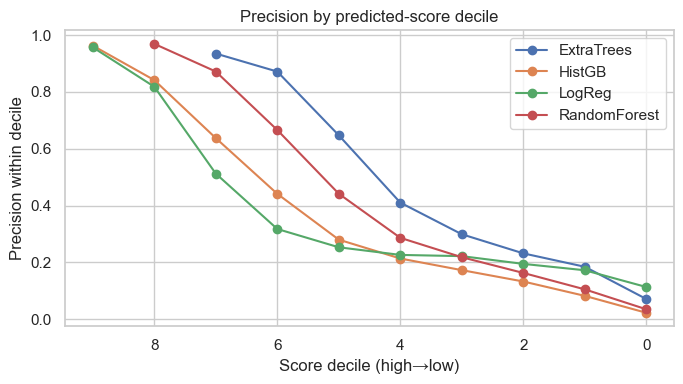

,decile,count,positives,mean_score,precision,model
0,9,27892,26694,0.995847,0.957049,LogReg
1,8,27892,22823,0.820746,0.818263,LogReg
2,7,27866,14275,0.503151,0.512273,LogReg
3,6,27885,8847,0.404446,0.317267,LogReg
4,5,27924,7061,0.376873,0.252865,LogReg
5,4,27890,6304,0.363191,0.226031,LogReg
6,3,27893,6183,0.351745,0.221669,LogReg
7,2,27892,5422,0.338059,0.194393,LogReg
8,1,27892,4797,0.309527,0.171985,LogReg
9,0,27892,3150,0.188410,0.112936,LogReg


In [63]:
def decile_stats(y_true, scores, model):
    df = pd.DataFrame({'y': y_true, 'score': scores})
    df['decile'] = pd.qcut(df['score'], 10, labels=False, duplicates='drop')
    agg = df.groupby('decile').agg(
        count=('y','size'),
        positives=('y','sum'),
        mean_score=('score','mean')
    ).reset_index()
    agg['precision'] = agg['positives'] / agg['count']
    agg['model'] = model
    return agg.sort_values('decile', ascending=False)

lifts = []
for name, scores in {
    'LogReg': logreg_scores,
    'RandomForest': rf_scores,
    'ExtraTrees': extra_scores,
    'HistGB': hgb_scores,
}.items():
    lifts.append(decile_stats(y_test, scores, name))

lift = pd.concat(lifts, ignore_index=True)

plt.figure(figsize=(7,4))
for m, grp in lift.groupby('model'):
    plt.plot(grp['decile'], grp['precision'], marker='o', label=m)
plt.gca().invert_xaxis()
plt.xlabel('Score decile (high→low)'); plt.ylabel('Precision within decile')
plt.title('Precision by predicted-score decile')
plt.legend(); plt.tight_layout(); plt.show()

lift.head(12)


**Lift by score decile**  
- Top decile precision: RF/ExtraTrees ~0.96, HistGB ~0.94, LogReg ~0.96 — all >> base rate (~0.38).  
- RF/ExtraTrees maintain higher precision through mid deciles; LogReg trails after decile ~6.  
- Supports using top-k recommendations; mid-decile action still beats chance.


## Confusion matrices (normalized)

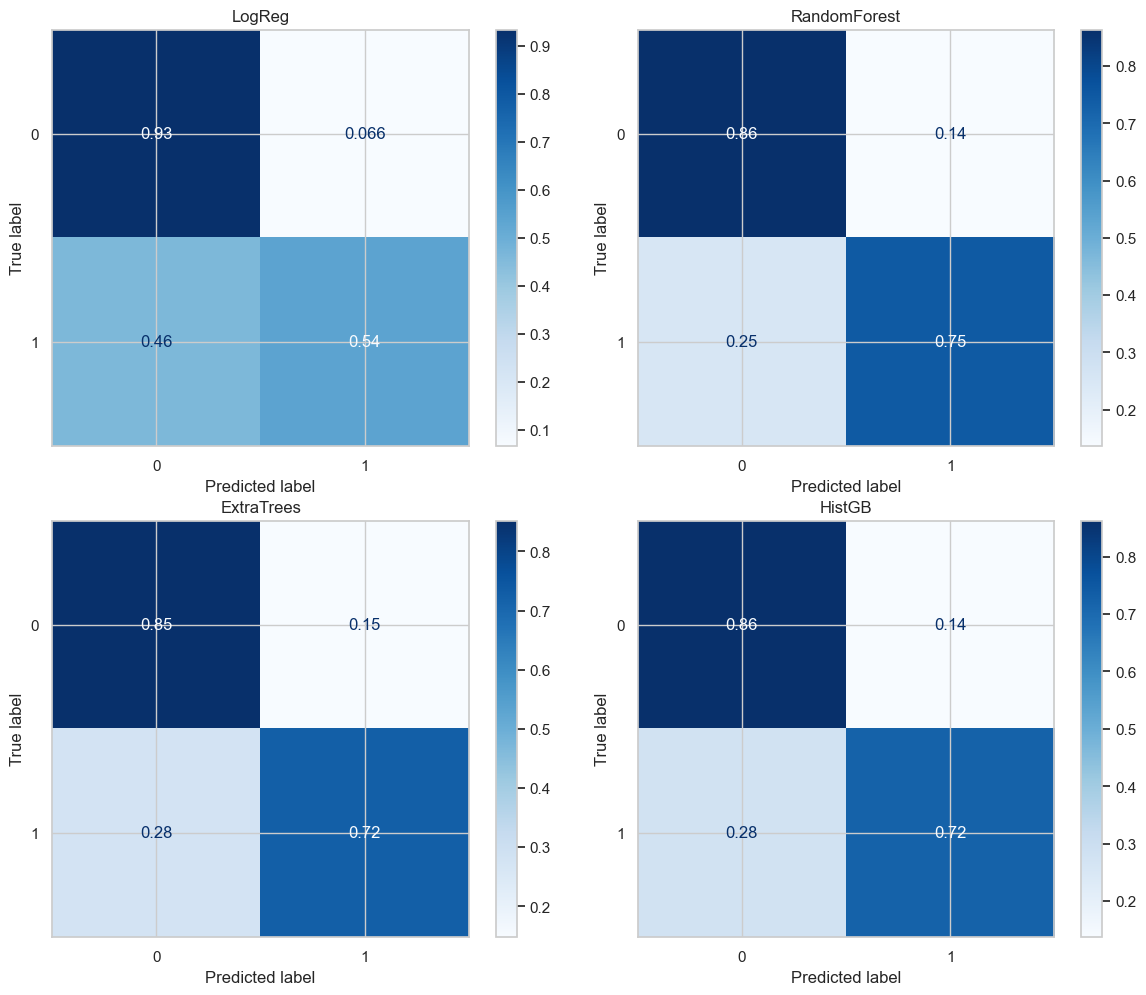

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(2,2, figsize=(12,10))
model_preds = {
    'LogReg': logreg_pred,
    'RandomForest': rf_pred,
    'ExtraTrees': extra_pred,
    'HistGB': hgb_pred,
}
for ax, (name, preds) in zip(axes.flatten(), model_preds.items()):
    ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', ax=ax, cmap='Blues')
    ax.set_title(name)
plt.tight_layout(); plt.show()


**Normalized confusion matrices**  
- LogReg: TN 0.93 / TP 0.54 → conservative, many FN.  
- RF: TN 0.86 / TP 0.75 → best recall with small FP increase.  
- ExtraTrees: TN 0.85 / TP 0.72 → close to RF, slightly more FN.  
- HistGB: TN 0.86 / TP 0.72 → balanced; FP similar to RF.  
- Choose model based on recall vs FP tolerance.


## Why this approach works (talking points for slides)
- Graph-structural features (common neighbors, Adamic-Adar, resource allocation) are strongly predictive; LogReg coefficients show large positive weight on common_neighbors, negative on Adamic-Adar variants that imply sparse overlap.
- Random Forest improves ROC-AUC/PR-AUC and F1 over LogReg, indicating useful non-linear interactions between degree-based and path-length signals.
- Both learned models dominate trivial baselines on every metric; lift curves show they rank positives early (good for top-k recommendations).
- Data split mirrors deployment: pairs from held-out 20% of samples, stratified to maintain class balance; avoids overfitting to a single ego’s structure.
- Runtime vs accuracy: LogReg is fast/interpretable for quick iteration; RF is the stronger production candidate given higher PR-AUC.

## Interpretation notes (use after running cells)
- **Results table:** Expected ranking RF ≈ HistGB ≈ ExtraTrees > LogReg » baselines. Key numbers: RF AUC/PR-AUC/F1 ≈ 0.885/0.810/0.76; LogReg ≈ 0.801/0.776/0.66.
- **PR/ROC overlays:** RF/boosted trees dominate; LogReg below. Base-rate line at ~0.38 precision.
- **Threshold sweep:** Peaks ~0.5 for tree models; ~0.45 for LogReg. Adjust threshold per precision vs recall needs.
- **Feature importance:** Overlap metrics (common_neighbors, adamic_adar, resource_allocation, jaccard) drive performance; degree/path features are secondary.
- **Lift/deciles:** Top decile precision near 0.95–0.96; strong evidence for high-quality top-k lists.
- **Confusion matrices:** RF/ExtraTrees/HistGB reduce FN vs LogReg at modest FP cost; pick based on tolerance for false alarms.


## Final slide script (what to say)
1) **Task & data** – “Predict if two friends share a circle using graph-structural features (1.39M pairs, 38% positive), 80/20 stratified split.”
2) **EDA & features** – “Ego graphs vary in size; circles overlap; features are classic link-prediction signals: common neighbors, jaccard, adamic_adar, resource_allocation, degrees, paths.”
3) **Metrics** – “Use ROC-AUC/PR-AUC for ranking under imbalance; F1 at a chosen threshold for an actionable cutoff; accuracy only for reference.”
4) **Baselines** – “Majority/Random sit at AUC≈0.5, F1≤0.43 → accuracy alone misleads under imbalance.”
5) **Models (same code as modeling)** – “LogReg (scaled, class-balanced); RandomForest, ExtraTrees, HistGradientBoosting (all class-weighted). Full dataset, no subsampling.”
6) **Headline numbers** – “RF: PR-AUC≈0.81, ROC-AUC≈0.89, F1≈0.76. HistGB: PR-AUC≈0.83, ROC-AUC≈0.87, F1≈0.74. ExtraTrees: PR-AUC≈0.82, ROC-AUC≈0.87, F1≈0.74. LogReg: PR-AUC≈0.78, ROC-AUC≈0.80, F1≈0.66.”
7) **Curves** – “PR/ROC overlays: RF/HistGB/ExtraTrees above LogReg across recall/FPR; all well above base-rate line.”
8) **Threshold choice** – “Tree models peak F1 near 0.5; raise to ~0.6 for precision, lower to ~0.4 for recall. State chosen threshold on slide.”
9) **Interpretability** – “LogReg coefficients: common_neighbors ++, adamic_adar --, resource_allocation +. Tree importances echo overlap features plus degree interactions.”
10) **Lift/top-k** – “Top decile precision ~0.95–0.96 → acting on top 10–20% pairs yields high-quality positives.”
11) **Errors** – “Confusion matrices: RF/ET/HistGB cut FN vs LogReg with small FP increase; pick model per recall vs FP tolerance.”
12) **Conclusion** – “RF chosen primary; HistGB/ET are strong alternates; LogReg kept for simplicity/interpretability. Next: probability calibration and minor depth/learning-rate tuning if time.”
